# Content



In [147]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import norm
from scipy.stats import skew

In [148]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

In [149]:
# import data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

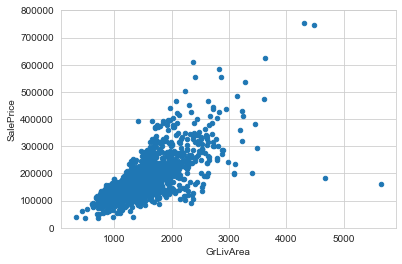

In [150]:
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

In [151]:
# drop outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

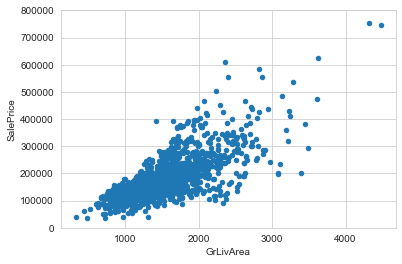

In [152]:
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000))

In [153]:
# check the size of each data set
y_train = train.SalePrice
full = pd.concat([train,test],ignore_index=True)


print("The size of train data is : {} ".format(train.shape))
print("The size of test data is : {} ".format(test.shape))
print("The size of full data is : {} ".format(full.shape))
print("The size of train data target varible is : {} ".format(y_train.shape))

The size of train data is : (1458, 81) 
The size of test data is : (1459, 80) 
The size of full data is : (2917, 81) 
The size of train data target varible is : (1458,) 


# Data Preprocessing

## Missing Values

In [154]:
full_na = (full.isnull().sum()/ len(full)) * 100
full_na = full_na.drop(full_na[full_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio':full_na})
missing_data.head(10)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
SalePrice,50.017141
FireplaceQu,48.680151
LotFrontage,16.660953
GarageYrBlt,5.450806
GarageFinish,5.450806
GarageQual,5.450806


Text(0.5, 1.0, 'Percent missing data by feature')

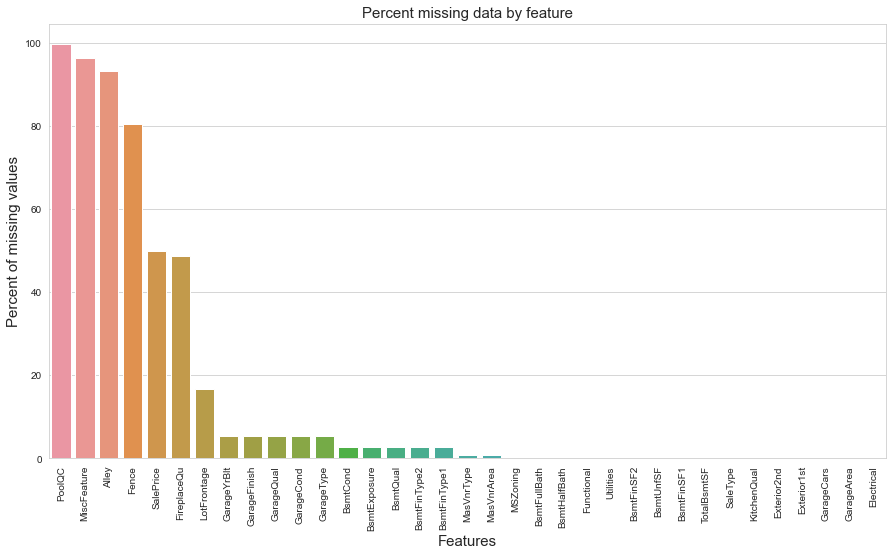

In [155]:
f, ax = plt.subplots(figsize=(15, 8))
plt.xticks(rotation='90')
sns.barplot(x=full_na.index, y=full_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [156]:
# For those NaN indicating not eligible  
# Categorical features
for col in ('PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 
            'GarageCond','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','MasVnrType'):
    full[col] = full[col].fillna('None')
# Numerical features
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF',
            'BsmtFullBath', 'BsmtHalfBath','MasVnrArea'):
    full[col] = full[col].fillna(0)

In [157]:
# full['MSZoning'] = full.groupby(['Neighborhood'])['MSZoning'].transform(lambda x:x.fillna(x.mode()))
full[full.Id == 2905]['MSZoning'] = 'RL'
full['MSZoning'] = full['MSZoning'].fillna('RM')

<AxesSubplot:xlabel='Neighborhood', ylabel='LotFrontage'>

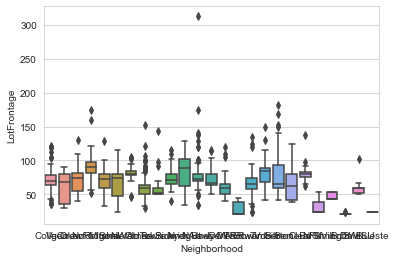

In [158]:
# Evaluate LotFrontage
# As some people using Neighborhood to estimate LotFrontage, which I thought is unreasonable
sns.boxplot(x='Neighborhood', y='LotFrontage', data=train)

<AxesSubplot:xlabel='LotAreaCut', ylabel='LotFrontage'>

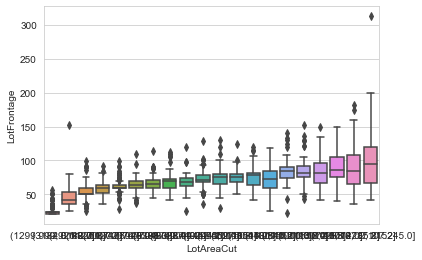

In [159]:
# LotFrontAge should be associated with the type of property and the lot size
# Althoght there is some outliers that have very large LotArea and very long LotFrontage
full["LotAreaCut"] = pd.qcut(full.LotArea,20)
sns.boxplot(x='LotAreaCut', y='LotFrontage', data=full)

<AxesSubplot:xlabel='MSZoning', ylabel='LotFrontage'>

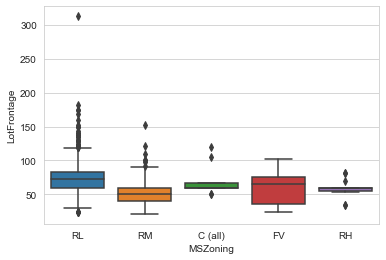

In [160]:
sns.boxplot(x='MSZoning', y='LotFrontage', data=train)

In [161]:
full[full.LotFrontage.isnull()].MSZoning.value_counts()

RL         426
RM          35
FV          20
RH           3
C (all)      2
Name: MSZoning, dtype: int64

In [162]:
full[full.MSZoning=='RL'][full.LotFrontage.isnull()].LotArea.describe()

count       426.000000
mean      13242.650235
std       13083.195645
min        1700.000000
25%        8966.250000
50%       11039.500000
75%       13460.000000
max      164660.000000
Name: LotArea, dtype: float64

In [163]:
full['LotFrontage'] = full.groupby(['MSZoning','LotAreaCut'])['LotFrontage'].transform(lambda x:x.fillna(x.median()))

In [164]:
# fill by most common str
for col in ('Exterior1st','Exterior2nd','Electrical','KitchenQual','SaleType'):
    full[col].fillna(full[col].mode()[0], inplace=True)

In [165]:
# for Utilities, nearly all records are 'ALLpub', thus we can safely drop it
full.drop('Utilities',axis=1,inplace=True)

In [166]:
# for Funtional, according to data description, NaN means 'Typ'
full["Functional"] = full["Functional"].fillna("Typ")

In [167]:
# No missing values for now
full.isnull().sum()[full.isnull().sum()>0]

SalePrice    1459
dtype: int64

# Exploratory Visualization


## Can overall condition/quality represent the condition/quality of each component?

In [168]:
QuaCon = full[['OverallQual','OverallCond','ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual',
             'FireplaceQu','GarageQual','GarageCond']]

QuaCon.drop(QuaCon[QuaCon.FireplaceQu == 'None'].index, inplace=True)
QuaCon.drop(QuaCon[QuaCon.GarageQual == 'None'].index, inplace=True)
QuaCon.drop(QuaCon[QuaCon.GarageCond == 'None'].index, inplace=True)
QuaCon.drop(QuaCon[QuaCon.BsmtQual == 'None'].index, inplace=True)
QuaCon.drop(QuaCon[QuaCon.BsmtCond == 'None'].index, inplace=True)

In [169]:
nn = {'Ex':10,'Gd':8,'TA':6,'Fa':4,'Po':2}
for col in ('ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual',
            'GarageCond'):
    QuaCon[col] = QuaCon[col].map(nn)
    QuaCon[col] = QuaCon[col].astype(float)

In [170]:
Qua = QuaCon.drop('OverallCond',axis=1)
Qua['OverallQual'] = Qua['OverallQual'].astype(float)
Con = QuaCon.drop('OverallQual',axis=1)
Con['OverallCond'] = Con['OverallCond'].astype(float)

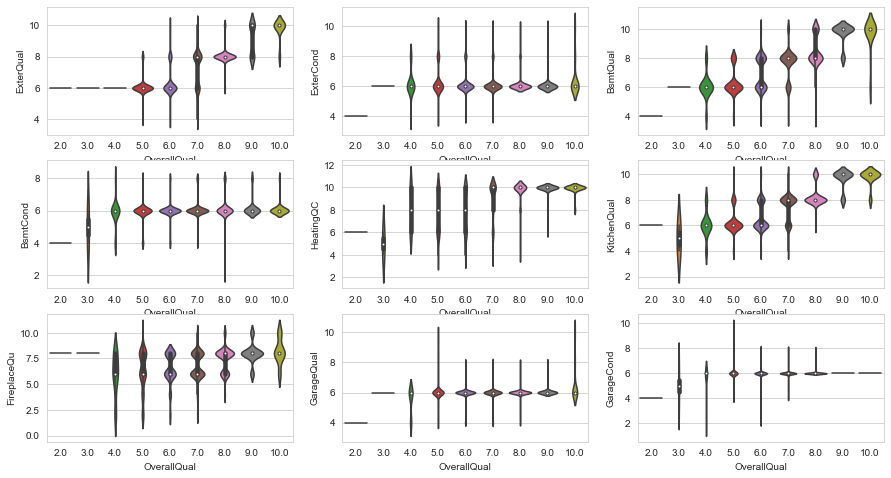

In [171]:
fig, axes = plt.subplots(figsize=(15, 8),nrows=3, ncols=3)
col = ('ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond')
for i in range(3):
    for j in range(3):
        sns.violinplot(x='OverallQual', y=col[3*i+j], data=Qua,figsize=(15,8),alpha=0.3,ax=axes[i,j])

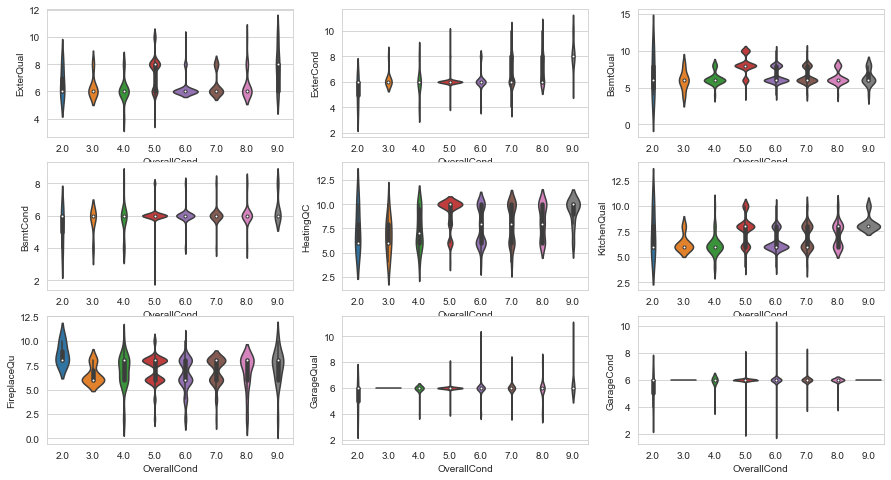

In [172]:
fig, axes = plt.subplots(figsize=(15, 8),nrows=3, ncols=3)
col = ('ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond')
for i in range(3):
    for j in range(3):
        sns.violinplot(x='OverallCond', y=col[3*i+j], data=Con,figsize=(15,8),alpha=0.3,ax=axes[i,j])

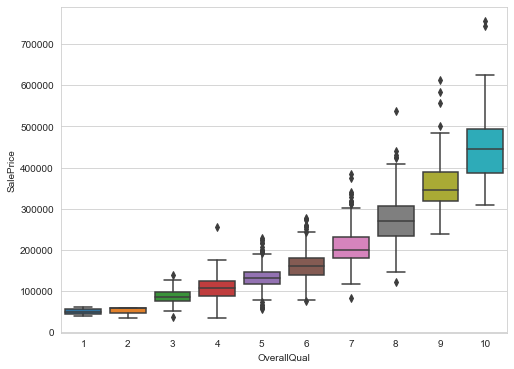

In [173]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([y_train, train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)

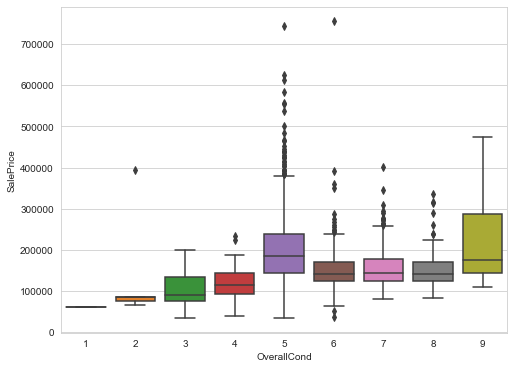

In [174]:
#box plot overallqual/saleprice
var = 'OverallCond'
data = pd.concat([y_train, train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)

Fun plot from which we can see the trend of salesprice is not strictly qudratic along with the built year. There is a peak for the properties built in around 1932 and before 1900, while the trend is still steadily going upward.
In general, I would believe that the older houses would worth more and the same for newer ones. It would be arbitrary to conclude the houses built in around 1932 would worth more by just plotting this graph. However, it might be wise to add one specific dummy to capture this feature.

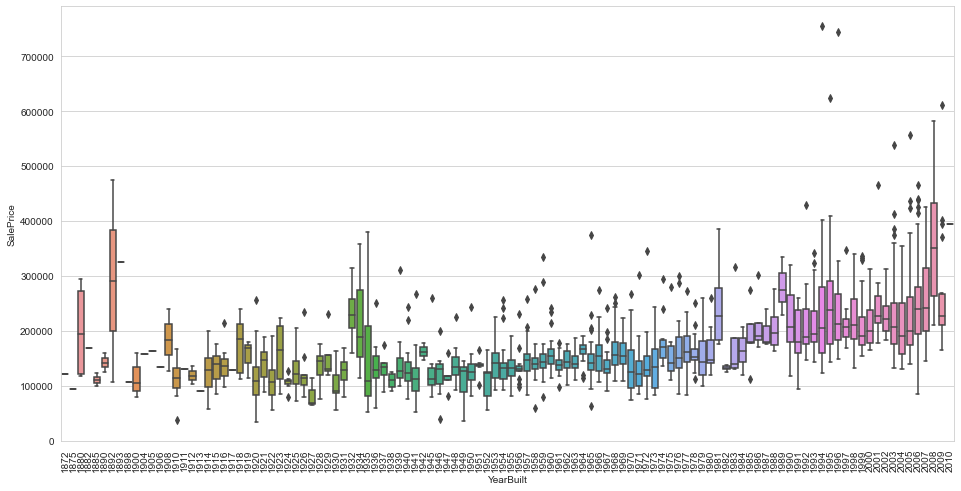

In [175]:
var = 'YearBuilt'
data = pd.concat([y_train, train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
plt.xticks(rotation=90);

In [176]:
def dum1930(aa):
    if 1931<=aa.YearBuilt<=1936:
        return 1
    else:
        return 0

In [177]:
full['Dum1930'] = full.apply(dum1930,axis=1)

# Feature Engineering

## Mapping categorical variables

In [178]:
full.groupby(['Neighborhood'])[['SalePrice']].agg(['mean','median','count'])

SalePrice                
                       mean    median count
Neighborhood                               
Blmngtn       194870.882353  191000.0    17
Blueste       137500.000000  137500.0     2
BrDale        104493.750000  106000.0    16
BrkSide       124834.051724  124300.0    58
ClearCr       212565.428571  200250.0    28
CollgCr       197965.773333  197200.0   150
Crawfor       210624.725490  200624.0    51
Edwards       127318.571429  119500.0    98
Gilbert       192854.506329  181000.0    79
IDOTRR        100123.783784  103000.0    37
MeadowV        98576.470588   88000.0    17
Mitchel       156270.122449  153500.0    49
NAmes         145847.080000  140000.0   225
NPkVill       142694.444444  146000.0     9
NWAmes        189050.068493  182900.0    73
NoRidge       335295.317073  301500.0    41
NridgHt       316270.623377  315000.0    77
OldTown       128225.300885  119000.0   113
SWISU         142591.360000  139500.0    25
Sawyer        136793.135135  135000.0    74
SawyerW       186555.796610  179900.0    59
Somerst       225379.837209  225500.0    86
StoneBr       310499.000000  278000.0    25
Timber        242247.447368  228475.0    38
Veenker       238772.727273  218000.0    11

* **Thus, I would map the Neighborhood to 7 tiers accroding to the median SalePrice values** 
        NridgHt: 1st (315000), NoRidge: 1st (301500.0) 
        StoneBr: 2nd (278000) 
        Timber: 3rd (228475.0), Somerst: 3rd (225500.0), Veenker: 3rd (218000.0), Crawfor: 3rd (200624.0), ClearCr: 3rd (200250.0), CollgCr: 3rd (197200.0), Blmngtn: 3rd (191000.0) 
        NWAmes: 4th (182900.0), Gilbert: 4th (181000.0), SawyerW: 4th (179900.0)  
        Mitchel: 5th (153500.0), NPkVill: 5th (146000.0), NAmes: 5th (140000.0), SWISU: 5th (139500.0), Blueste: 5th (137500.0), Sawyer: 5th (135000.0), BrkSide: 5th (124300.0), Edwards: 5th (119500.0), OldTown: 5th (119000.0)  
        BrDale: 6th (106000.0), IDOTRR: 6th (103000.0) 
        MeadowV: 7th (88000.0)
* **Similarly, I would also use this method to map MSSubClass, and Quality/Condition features**

In [179]:
full.groupby(['MSSubClass'])[['SalePrice']].agg(['mean','median','count'])

SalePrice                
                     mean    median count
MSSubClass                               
20          185224.811567  159250.0   536
30           95829.724638   99900.0    69
40          156125.000000  142500.0     4
45          108591.666667  107500.0    12
50          143302.972222  132000.0   144
60          240403.542088  216000.0   297
70          166772.416667  156000.0    60
75          192437.500000  163500.0    16
80          169736.551724  166500.0    58
85          147810.000000  140750.0    20
90          133541.076923  135980.0    52
120         200779.080460  192000.0    87
150                   NaN       NaN     0
160         138647.380952  146000.0    63
180         102300.000000   88500.0    10
190         129613.333333  128250.0    30

In [180]:
def map_values():
    full["oNeighborhood"] = full.Neighborhood.map({'NridgHt':'1st', 'NoRidge':'1st',
                                                   'StoneBr':'2nd',
                                                   'Timber': '3rd', 'Somerst': '3rd', 'Veenker': '3rd', 'Crawfor': '3rd', 'ClearCr': '3rd', 'CollgCr': '3rd', 'Blmngtn': '3rd',
                                                   'NWAmes': '4th', 'Gilbert': '4th', 'SawyerW': '4th',
                                                   'Mitchel': '5th', 'NPkVill': '5th', 'NAmes': '5th', 'SWISU': '5th', 'Blueste': '5th', 'Sawyer': '5th', 'BrkSide': '5th', 'Edwards': '5th', 'OldTown': '5th',
                                                   'BrDale': '6th', 'IDOTRR': '6th',
                                                   'MeadowV': '7th'})
    full["oMSSubClass"] = full.MSSubClass.map({60:'1st', 120:'1st',
                                               80:'2nd', 75:'2nd', 20:'2nd', 70:'2nd',
                                               160:'3rd', 40:'3rd', 85:'3rd', 90:'3rd', 50:'3rd', 190:'3rd',
                                               45:'4th', 30:'4th',180:'4th',
                                               150:'2nd'})
    full['oOverallQual'] = full.OverallQual.map({10:5, 9:5, 8:4, 7:4 ,6:3, 5:3, 4:2, 3:2, 2:1, 1:1})
    full['oOverallCond'] = full.OverallCond.map({10:5, 9:5, 8:4, 7:4 ,6:3, 5:3, 4:2, 3:2, 2:1, 1:1})
    
    full['oExterQual'] = full.ExterQual.map({'Ex':'Gd', 'Gd':'Gd', 'TA':'TA', 'Fa':'TA' ,'Po':'Po', 'NA':'None', 'None':'None'})
    full['oExterCond'] = full.ExterCond.map({'Ex':'Gd', 'Gd':'Gd', 'TA':'TA', 'Fa':'TA' ,'Po':'Po', 'NA':'None', 'None':'None'})
    full['oBsmtQual'] = full.BsmtQual.map({'Ex':'Gd', 'Gd':'Gd', 'TA':'TA', 'Fa':'TA' ,'Po':'Po', 'NA':'None', 'None':'None'})
    full['oBsmtCond'] = full.BsmtCond.map({'Ex':'Gd', 'Gd':'Gd', 'TA':'TA', 'Fa':'TA' ,'Po':'Po', 'NA':'None', 'None':'None'})
    full['oHeatingQC'] = full.HeatingQC.map({'Ex':'Gd', 'Gd':'Gd', 'TA':'TA', 'Fa':'TA' ,'Po':'Po', 'NA':'None', 'None':'None'})
    full['oKitchenQual'] = full.KitchenQual.map({'Ex':'Gd', 'Gd':'Gd', 'TA':'TA', 'Fa':'TA' ,'Po':'Po', 'NA':'None', 'None':'None'})
    full['oFireplaceQu'] = full.FireplaceQu.map({'Ex':'Gd', 'Gd':'Gd', 'TA':'TA', 'Fa':'TA' ,'Po':'Po', 'NA':'None', 'None':'None'})
    full['oGarageQual'] = full.GarageQual.map({'Ex':'Gd', 'Gd':'Gd', 'TA':'TA', 'Fa':'TA' ,'Po':'Po', 'NA':'None', 'None':'None'})
    full['oGarageCond'] = full.GarageCond.map({'Ex':'Gd', 'Gd':'Gd', 'TA':'TA', 'Fa':'TA' ,'Po':'Po', 'NA':'None', 'None':'None'})
    full['oPoolQC'] = full.PoolQC.map({'Ex':'Gd', 'Gd':'Gd', 'TA':'TA', 'Fa':'TA' ,'Po':'Po', 'NA':'None', 'None':'None'})
    
    return 'Value Mapping Finished!'    

In [181]:
map_values()

'Value Mapping Finished!'

In [182]:
# drop the replaced and unwanted columns 
for col in ('Id','SalePrice','LotAreaCut','Neighborhood','MSSubClass','OverallQual','OverallCond','ExterQual','ExterCond',
            'BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC'):
    full.drop(col,axis=1,inplace=True)

In [183]:
# prepare a copy of full data for feature selection
full2 = full.copy()

## Feature Selection
### Apply pipeline
Before conducting feature selection, I would firstly set pipeline, as a set of transformations for simple setup \
For pipeline I would do it includes,
* add more features by combining current ones

In [184]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
        X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]           
        X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
        X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
        X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
        X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
        
        return X

* modify time variables
        As the housing sales happened within four years, in order to fully consider the specific time related features for each property and the possible qudratic impacts, here I modify the time features to specificly capture the time related impacts 

In [185]:
def remodgap(aa):
    if aa.YearBuilt == aa.YearRemodAdd:
        return 0
    else:
        val = aa.YrSold - aa.YearRemodAdd
        return val

In [186]:
class time_var(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    

    
    def transform(self,X):
        X['BuiltGap'] = X.YrSold - X.YearBuilt
        X['RemodGap'] = X.apply(remodgap,axis=1)
        X['BuiltGap2'] = np.square(X.BuiltGap)
        X['RemodGap2'] = np.square(X.RemodGap)
        
        X.drop('YearBuilt',axis=1,inplace=True)
        X.drop('YearRemodAdd',axis=1,inplace=True)
        X.drop('GarageYrBlt',axis=1,inplace=True)
        
        return X

* define the type of categorical variables for setting dummies

In [187]:
class set_str(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X['oOverallQual'] = X['oOverallQual'].astype(str)
        X['oOverallCond'] = X['oOverallCond'].astype(str)
        X['YrSold'] = X['YrSold'].astype(str)
        X['MoSold'] = X['MoSold'].astype(str)
        X['BsmtFullBath'] = X['BsmtFullBath'].astype(str)
        X['BsmtHalfBath'] =X['BsmtHalfBath'].astype(str)
        X['FullBath'] =X['FullBath'].astype(str)
        X['HalfBath'] =X['HalfBath'].astype(str)
        X['BedroomAbvGr'] =X['BedroomAbvGr'].astype(str)
        X['KitchenAbvGr'] =X['KitchenAbvGr'].astype(str)
        X['TotRmsAbvGrd'] =X['TotRmsAbvGrd'].astype(str)
        X['GarageCars'] =X['GarageCars'].astype(str)
        
        return X
        

* modify the skewed features using log(1+x) 

In [188]:
class skew_dummies(BaseEstimator, TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        
        X['BuiltGap'] = X['BuiltGap'].astype(str)
        X['RemodGap'] = X['RemodGap'].astype(str)
        X['BuiltGap2'] = X['BuiltGap2'].astype(str)
        X['RemodGap2'] = X['RemodGap2'].astype(str)

        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        
        X['BuiltGap'] = X['BuiltGap'].astype(float)
        X['RemodGap'] = X['RemodGap'].astype(float)
        X['BuiltGap2'] = X['BuiltGap2'].astype(float)
        X['RemodGap2'] = X['RemodGap2'].astype(float)
        X = pd.get_dummies(X)

        return X

In [189]:
# build pipeline
pipe = Pipeline([
    ('add_feature', add_feature()),
    ('time_var', time_var()),
    ('set_str', set_str()),
    ('skew_dummies', skew_dummies(skew=0.5)),
    
    ])

In [190]:
full2.head()

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Dum1930,oNeighborhood,oMSSubClass,oOverallQual,oOverallCond,oExterQual,oExterCond,oBsmtQual,oBsmtCond,oHeatingQC,oKitchenQual,oFireplaceQu,oGarageQual,oGarageCond,oPoolQC
0,RL,65.0,8450,Pave,None,Reg,Lvl,Inside,Gtl,Norm,Norm,1Fam,2Story,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,PConc,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,8,Typ,0,Attchd,2003.0,RFn,2.0,548.0,Y,0,61,0,0,0,0,None,None,0,2,2008,WD,Normal,0,3rd,1st,4,3,Gd,TA,Gd,TA,Gd,Gd,None,TA,TA,None
1,RL,80.0,9600,Pave,None,Reg,Lvl,FR2,Gtl,Feedr,Norm,1Fam,1Story,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,CBlock,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,6,Typ,1,Attchd,1976.0,RFn,2.0,460.0,Y,298,0,0,0,0,0,None,None,0,5,2007,WD,Normal,0,3rd,2nd,3,4,TA,TA,Gd,TA,Gd,TA,TA,TA,TA,None
2,RL,68.0,11250,Pave,None,IR1,Lvl,Inside,Gtl,Norm,Norm,1Fam,2Story,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,PConc,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,6,Typ,1,Attchd,2001.0,RFn,2.0,608.0,Y,0,42,0,0,0,0,None,None,0,9,2008,WD,Normal,0,3rd,1st,4,3,Gd,TA,Gd,TA,Gd,Gd,TA,TA,TA,None
3,RL,60.0,9550,Pave,None,IR1,Lvl,Corner,Gtl,Norm,Norm,1Fam,2Story,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,BrkTil,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,7,Typ,1,Detchd,1998.0,Unf,3.0,642.0,Y,0,35,272,0,0,0,None,None,0,2,2006,WD,Abnorml,0,3rd,2nd,4,3,TA,TA,TA,Gd,Gd,Gd,Gd,TA,TA,None
4,RL,84.0,14260,Pave,None,IR1,Lvl,FR2,Gtl,Norm,Norm,1Fam,2Story,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,PConc,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,9,Typ,1,Attchd,2000.0,RFn,3.0,836.0,Y,192,84,0,0,0,0,None,None,0,12,2008,WD,Normal,0,1st,1st,4,3,Gd,TA,Gd,TA,Gd,Gd,TA,TA,TA,None


In [191]:
data_pipe = pipe.fit_transform(full2)

In [192]:
data_pipe.shape

(2917, 336)

In [193]:
data_pipe.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Dum1930,TotalHouse,TotalArea,Bsmt,Rooms,PorchArea,TotalPlace,BuiltGap,RemodGap,BuiltGap2,RemodGap2,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,BsmtFullBath_0.0,BsmtFullBath_1.0,BsmtFullBath_2.0,BsmtFullBath_3.0,BsmtHalfBath_0.0,BsmtHalfBath_1.0,BsmtHalfBath_2.0,FullBath_0,FullBath_1,FullBath_2,FullBath_3,FullBath_4,HalfBath_0,HalfBath_1,HalfBath_2,BedroomAbvGr_0,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,BedroomAbvGr_8,KitchenAbvGr_0,KitchenAbvGr_1,KitchenAbvGr_2,KitchenAbvGr_3,TotRmsAbvGrd_10,TotRmsAbvGrd_11,TotRmsAbvGrd_12,TotRmsAbvGrd_13,TotRmsAbvGrd_14,TotRmsAbvGrd_15,TotRmsAbvGrd_2,TotRmsAbvGrd_3,TotRmsAbvGrd_4,TotRmsAbvGrd_5,TotRmsAbvGrd_6,TotRmsAbvGrd_7,TotRmsAbvGrd_8,TotRmsAbvGrd_9,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageCars_0.0,GarageCars_1.0,GarageCars_2.0,GarageCars_3.0,GarageCars_4.0,GarageCars_5.0,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,YrSold_2006,YrSold_2007,YrSold_2008,Y

## Feature Selection

        by simply put data into LASSO model to verify the relative importance of each feature

In [194]:
#applying log(1+x) transformation for target variable
y_train = np.log1p(y_train)

In [195]:
scaler = RobustScaler()

In [196]:
n_train=train.shape[0]

X = data_pipe[:n_train]
test_X = data_pipe[n_train:]
y= y_train

X_scaled = scaler.fit(X).transform(X)
# test_X_scaled = scaler.transform(test_X)

In [197]:
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y)

Lasso(alpha=0.001)

In [198]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=data_pipe.columns)

In [199]:
FI_lasso.sort_values("Feature Importance",ascending=False)

,Feature Importance
oOverallQual_5,2.164639e-01
GrLivArea,1.062206e-01
oNeighborhood_2nd,8.799543e-02
Functional_Typ,8.206756e-02
TotalPlace,8.120824e-02
oOverallCond_5,7.834725e-02
oOverallCond_4,7.542141e-02
oNeighborhood_1st,7.061665e-02
TotalArea,6.502544e-02
KitchenAbvGr_1,6.314413e-02


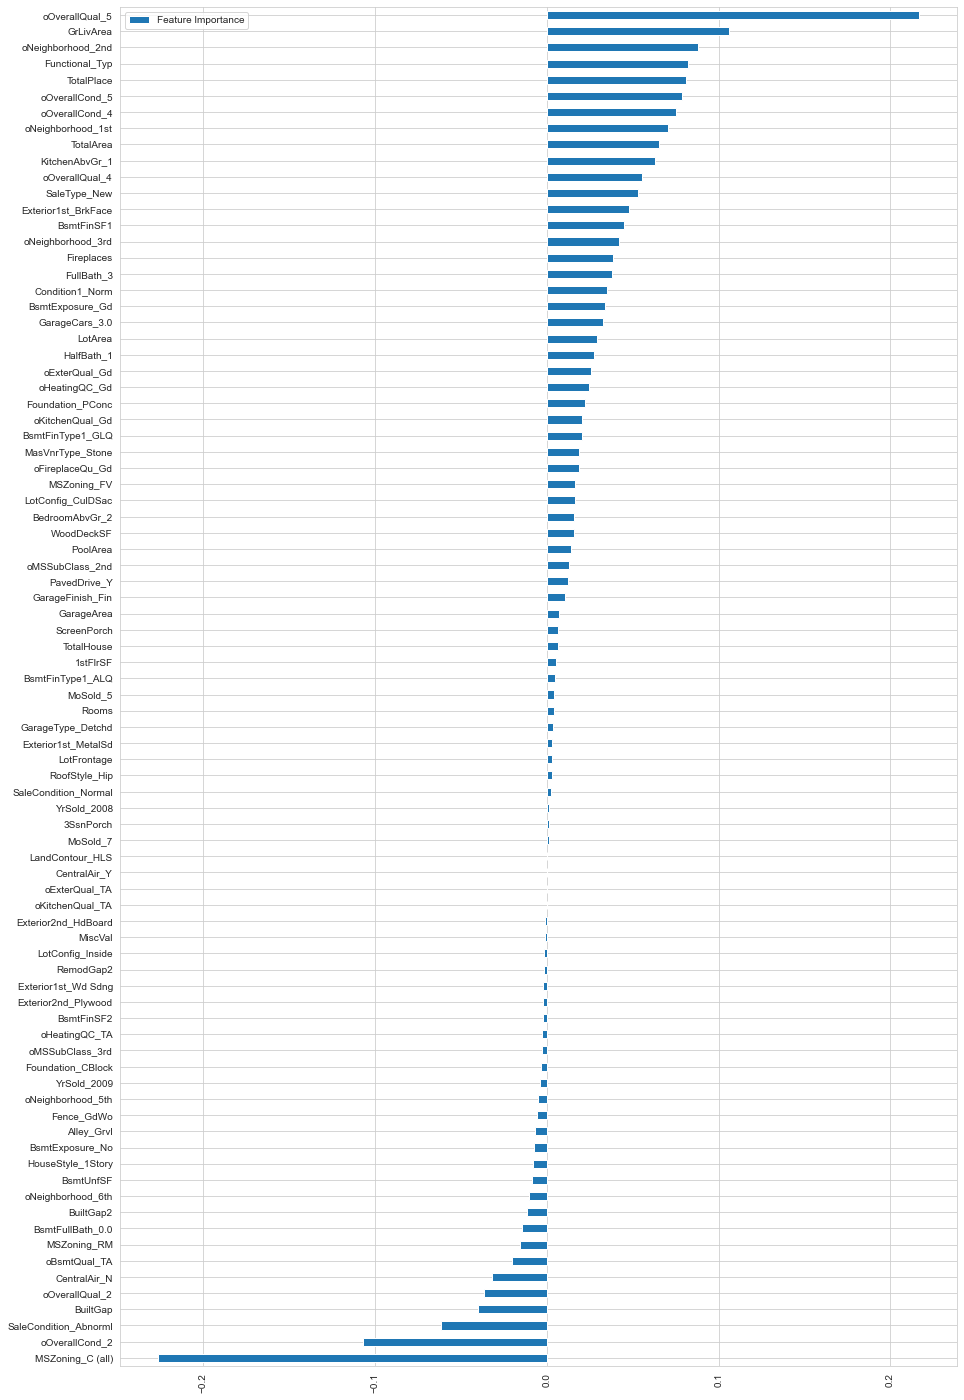

In [200]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

        Good thing for reducing features -- avoid overfitting, which is quite common in my previous attempts that showing the score for test set is higher than my cross validation set.
        So the basic principle for reducing features is, according to the above regression results and dropping those features with less importance.
        And the method I am going to use is to add one more step in my pipeline calls "drop_feature"

In [201]:
class drop_feature(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X['SaleType_New'] = X.SaleType.apply(lambda x:[1,0][x=='New'])
        X['YrSold_2009'] = X.YrSold.apply(lambda x:[1,0][x==2009])
        for col in ('GarageType','GarageCars','BsmtFullBath','BsmtHalfBath','oExterCond','oFireplaceQu',
                    'oGarageQual','oPoolQC','Fence','MiscFeature','Condition2','Alley','LotShape','LandContour',
                   'Exterior2nd','BsmtFinType2','SaleType','YrSold'):
            X.drop(col,axis=1,inplace=True) 
        return X

In [202]:
# modify the previous
class set_str(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X):
        X['oOverallQual'] = X['oOverallQual'].astype(str)
        X['oOverallCond'] = X['oOverallCond'].astype(str)
        X['MoSold'] = X['MoSold'].astype(str)
        X['SaleType_New'] = X['SaleType_New'].astype(str)
        X['YrSold_2009'] = X['YrSold_2009'].astype(str)
        X['FullBath'] =X['FullBath'].astype(str)
        X['HalfBath'] =X['HalfBath'].astype(str)
        X['BedroomAbvGr'] =X['BedroomAbvGr'].astype(str)
        X['KitchenAbvGr'] =X['KitchenAbvGr'].astype(str)
        X['TotRmsAbvGrd'] =X['TotRmsAbvGrd'].astype(str)
        X['Fireplaces'] =X['Fireplaces'].astype(str)
        
        return X
        

In [203]:
# rebuild pipeline
pipe = Pipeline([
    ('time_var', time_var()),
    ('add_feature', add_feature()),
    ('drop_feature', drop_feature()),
    ('set_str', set_str()),
    ('skew_dummies', skew_dummies(skew=0.5)),
    
    ])

In [204]:
full1 = full.copy()

In [205]:
data_pipe = pipe.fit_transform(full1)

In [206]:
data_pipe['GarageArea'] = np.log1p(data_pipe['GarageArea'])

In [207]:
data_pipe.shape

(2917, 244)

In [208]:
data_pipe.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,Dum1930,BuiltGap,RemodGap,BuiltGap2,RemodGap2,TotalHouse,TotalArea,Bsmt,Rooms,PorchArea,TotalPlace,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,FullBath_0,FullBath_1,FullBath_2,FullBath_3,FullBath_4,HalfBath_0,HalfBath_1,HalfBath_2,BedroomAbvGr_0,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_5,BedroomAbvGr_6,BedroomAbvGr_8,KitchenAbvGr_0,KitchenAbvGr_1,KitchenAbvGr_2,KitchenAbvGr_3,TotRmsAbvGrd_10,TotRmsAbvGrd_11,TotRmsAbvGrd_12,TotRmsAbvGrd_13,TotRmsAbvGrd_14,TotRmsAbvGrd_15,TotRmsAbvGrd_2,TotRmsAbvGrd_3,TotRmsAbvGrd_4,TotRmsAbvGrd_5,TotRmsAbvGrd_6,TotRmsAbvGrd_7,TotRmsAbvGrd_8,TotRmsAbvGrd_9,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,Fireplaces_0,Fireplaces_1,Fireplaces_2,Fireplaces_3,Fireplaces_4,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y,MoSold_1,MoSold_10,MoSold_11,MoSold_12,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,oNeighborhood_1st,oNeighborhood_2nd,oNeighborhood_3rd,oNeighborhood_4th,oNeighborhood_5th,oNeighborhood_6th,oNeighborhood_7th,oMSSubClass_1st,oMSSubClass_2nd,oMSSubClass_3rd,oMSSubClass_4th,oOverallQual_1,oOverallQual_2,oOverallQual_3,oOverallQual_4,oOverallQual_5,oOverallCond_1,oOverallCond_2,oOverallCond_3,oOverallCond_4,oOverallCond_5,oExterQual_Gd,oExterQual_TA,oBsmtQual_Gd,oBsmtQual_None,oBsmtQual_TA,oBsmtCond_Gd,oBsmtCond_None,oBsmtCond_Po,oBsmtCond_TA,oHeatingQC_Gd,oHeatingQC_Po,oHeatingQC_TA,oKitchenQual_Gd,oKitchenQual_TA,oGarageCond_Gd,oGarageCond_None,oGarageCond_Po,oGarageCond_TA,SaleType_New_0,SaleType_New_1,YrSold_2009_0,YrSold_2009_1
0,4.189655,9.042040,5.283204,6.561031,0.0,5.017280,6.753438,6.753438,6.751101,0.0,7.444833,6.308098,0.000000,4.127134,0.000000,0.0,0.0,0.0,0.0,0.0,5.0,0.0,25.0,0.0,7.850493,8.043984,6.753438,2.397895,4.127134,8.063378,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0

In [209]:
# very strange one that being sold (in 2017) before being built (in 2008)
full[full.index==2547]

,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,Foundation,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Dum1930,oNeighborhood,oMSSubClass,oOverallQual,oOverallCond,oExterQual,oExterCond,oBsmtQual,oBsmtCond,oHeatingQC,oKitchenQual,oFireplaceQu,oGarageQual,oGarageCond,oPoolQC
2547,RL,128.0,39290,Pave,None,IR1,Bnk,Inside,Gtl,Norm,Norm,1Fam,1Story,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,PConc,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,15,Typ,2,Attchd,2008.0,Fin,3.0,1154.0,Y,546,484,0,0,0,0,None,None,17000,10,2007,New,Partial,0,5th,2nd,5,3,Gd,TA,Gd,TA,Gd,Gd,Gd,TA,TA,None


# Modelling & Evaluation

Prepare two data set
* PCA
* Doing nothing

In [210]:
# PCA
pca = PCA(n_components='mle')
data_pipe = scaler.fit(data_pipe).transform(data_pipe)
full_pca_dum = data_pipe
pca.fit(full_pca_dum)
full_pca_dum = pca.transform(full_pca_dum)

In [211]:
n_train=train.shape[0]

X_pca = full_pca_dum[:n_train]
test_X_pca = full_pca_dum[n_train:]
y= y_train

In [212]:
# Counterpart -- doing nothing
X = data_pipe[:n_train]
test_X = data_pipe[n_train:]
y= y_train

In [213]:
X_pca.shape,X.shape

((1458, 201), (1458, 244))

In [214]:
# define cross validation strategy
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [215]:
models = [LinearRegression(),Ridge(),Lasso(),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(),SGDRegressor(),BayesianRidge(),KernelRidge(),
          ExtraTreesRegressor(),XGBRegressor()]
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]

In [216]:
# PCA
for name, model in zip(names, models):
    score = rmse_cv(model, X_pca, y)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 22365834409.829002, 25895973909.0449
Ridge: 0.120261, 0.0080
Lasso: 0.375713, 0.0163
RF: 0.168618, 0.0083
GBR: 0.154111, 0.0083
SVR: 0.135371, 0.0068
LinSVR: 0.130910, 0.0063
Ela: 0.339523, 0.0168
SGD: 1.489510, 1.9982
Bay: 0.117177, 0.0066
Ker: 14.160620, 0.7661
Extra: 0.159540, 0.0114
[00:49:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:49:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Xgb: 0.160154, 0.0091


In [217]:
# Counterpart
for name, model in zip(names, models):
    score = rmse_cv(model, X, y)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 0.127705, 0.0098
Ridge: 0.120261, 0.0080
Lasso: 0.380080, 0.0163
RF: 0.138190, 0.0067
GBR: 0.123007, 0.0079
SVR: 0.133648, 0.0067
LinSVR: 0.164920, 0.0575
Ela: 0.371403, 0.0159
SGD: 585532819.664228, 59035714.1741
Bay: 0.117177, 0.0066
Ker: 0.166714, 0.0173
Extra: 0.132578, 0.0121
[00:50:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:50:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:50:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:50:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:50:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Xgb: 0.123399, 0.0066



* Here I choose the models of Ridge, GBR, SVR, Bay, Extra and using data without PCA

# Hyperparameters tuning

In [218]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

## Ridge

In [219]:
grid(Ridge()).grid_get(X,y,{'alpha':[10,15,20,25,30,35,40,45]})

{'alpha': 10} 0.11747610447020738
          params  mean_test_score  std_test_score
0  {'alpha': 10}         0.117476        0.001448
1  {'alpha': 15}         0.118081        0.001407
2  {'alpha': 20}         0.118770        0.001389
3  {'alpha': 25}         0.119460        0.001381
4  {'alpha': 30}         0.120131        0.001380
5  {'alpha': 35}         0.120776        0.001383
6  {'alpha': 40}         0.121395        0.001388
7  {'alpha': 45}         0.121989        0.001394


# SVR

In [220]:
grid(SVR()).grid_get(X,y,{'C':[11,12,13,14,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})

{'C': 15, 'epsilon': 0.009, 'gamma': 0.0004, 'kernel': 'rbf'} 0.11723200056109108
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.118758   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.117949   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.118680   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.117935   
4   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.118415   
5   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.117810   
6   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.118326   
7   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.117787   
8   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.118099   
9   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.117644   
10  {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.118037   
11  {'C': 13, 'epsilon': 0.009

# Ensemble Methods

In [221]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
    
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [222]:
ridge = Ridge(alpha=10)
gbr = GradientBoostingRegressor()
svr = SVR(C= 15, epsilon= 0.009, gamma= 0.0004, kernel='rbf')
bay = BayesianRidge()
extra = ExtraTreesRegressor()

In [223]:
# assign weight
w1 = 0.25
w2 = 0.2
w3 = 0.1
w4 = 0.25
w5 = 0.2

In [224]:
weight_avg = AverageWeight(mod = [ridge,gbr,svr,bay,extra],weight=[w1,w2,w3,w4,w5])

In [225]:
rmse_cv(weight_avg,X,y),  rmse_cv(weight_avg,X,y).mean()

(array([0.10368021, 0.11933707, 0.12234586, 0.10537682, 0.11350371]),
 0.11309535454627766)

## Stacking

In [226]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [227]:
a = SimpleImputer().fit_transform(X)
b = SimpleImputer().fit_transform(y.values.reshape(-1,1)).ravel()

In [228]:
stack_model = stacking(mod = [ridge,gbr,svr,bay,extra],meta_model=bay)

In [229]:
print(rmse_cv(stack_model,a,b))
print(rmse_cv(stack_model,a,b).mean())

[0.10618945 0.11895924 0.12467354 0.10523708 0.11317193]
0.11358551611439646


In [230]:
X_train_stack, X_test_stack = stack_model.get_oof(a,b,test_X)
X_train_stack.shape, a.shape

((1458, 5), (1458, 244))

In [231]:
X_train_add = np.hstack((a,X_train_stack))
X_test_add = np.hstack((test_X,X_test_stack))
X_train_add.shape, X_test_add.shape

((1458, 249), (1459, 249))

In [232]:
print(rmse_cv(stack_model,X_train_add,b))
print(rmse_cv(stack_model,X_train_add,b).mean())

[0.11151568 0.11947652 0.12190118 0.10580514 0.11412946]
0.11456320535271511


## Submission

In [233]:
stack_model = stacking(mod=[ridge,gbr,svr,bay,extra],meta_model=bay)
stack_model.fit(a,b)

stacking(meta_model=BayesianRidge(),
         mod=[Ridge(alpha=10), GradientBoostingRegressor(),
              SVR(C=15, epsilon=0.009, gamma=0.0004), BayesianRidge(),
              ExtraTreesRegressor()])

In [234]:
pred = np.expm1(stack_model.predict(test_X))

In [235]:
submission=pd.DataFrame({'Id':test.Id,'SalePrice':pred})
submission.to_csv('submission.csv',index=False,encoding='utf-8')